In [1]:
import numpy as np
import csv
import matplotlib.pyplot as plt
import astropy.constants as cte
import astropy.units as un
import astropy.cosmology
from astropy.cosmology import Planck15 as cosmo
import emcee
import scipy.optimize as op
import corner
import scipy

In [2]:
c=cte.c
Msun=cte.M_sun

In [3]:
file = open("/Users/mariajesusfloresmoraga/Desktop/DSFG/T1 f2.csv")
csvreader = csv.reader(file)
header = []
header = next(csvreader)

rows = []
for row in csvreader:
        rows.append(row)

ID= []

v1=[]
ev1=[]

v2=[]
ev2=[]

v3=[]
ev3=[]

l1=[]
el1=[]

l2=[]
el2=[]

l3=[]
el3=[]


for j in rows:   
    
    ID.append(j[0])
    
    v1.append(float(j[3]))
    ev1.append(float(j[4]))
    v2.append(float(j[5]))
    ev2.append(float(j[6]))
    v3.append(float(j[7]))
    ev3.append(float(j[8]))
    l1.append(float(j[9]))
    el1.append(float(j[10]))
    l2.append(float(j[11]))
    el2.append(float(j[12]))
    l3.append(float(j[13]))
    el3.append(float(j[14]))


In [4]:
v_=[148,218,278]*un.GHz
l__=[500,350,250]*un.um
v=v_.to("Hz").value
l_=(c.to("um/s"))/(np.array([500,350,250])*un.um)
l=l_.to("Hz").value
vf=np.concatenate((v, l))

In [5]:
def tau(z,M_,d_,vf): 
    vf=vf*un.Hz
    d_=d_*un.kpc
    v0=353*un.GHz
    b=2
    M=Msun * 10** M_
    k0=0.15*(un.m**2/un.kg) 
    tau=k0*(vf/v0)**b *(z+1)**b * M/(np.pi*(d_/2)**2)
    return tau.to("")

In [6]:
def P(vf,T,z):
    vf=vf*un.Hz
    T=T*un.K
    h=cte.h
    K=cte.k_B
    A=2*h/(c**2)
    a=(h*vf*(1+z)/(K*T))
    B=vf**3/(np.e**(a.value) -1)
    P=(A*B).to("mJy")
    return P

In [7]:
def modelSv(vf,z,T,M_,d_):
    
    b=2
    v0=353*un.GHz
    D=cosmo.angular_diameter_distance(z)
    M=Msun*(10**M_)
    
    TAU=tau(z,M_,d_,vf)
    PL=P(vf,T,z)
    
    vf=vf*un.Hz
    T=T*un.K
    d_=d_*un.kpc
    
    O=np.pi*(d_/2)**2 * (D**-2)
    
    S_=O*(1-np.e**-TAU)*PL
    S=S_.to("mJy")
    return S.value

In [8]:
def A(z,Tc,M_,d_,vf): 


    v0=353*un.GHz
    b=2
    
    Tc=Tc*un.K
    Tvariable=(np.linspace(Tc.value,1000,10000)) *un.K
    
    integrales=[]
    
    for i in vf:
        ARG = modelSv(i,z,Tvariable,M_,d_)*un.mJy *(Tvariable)**-7
        integrales.append(scipy.integrate.trapz(ARG,x=Tvariable))
    
    return integrales

In [9]:
def modelSobs(vf,z,Tc,M_,d_): #Como SPT no entrega Tc tomamos Tc= T-10]
    
    b=2
    v0=353*un.GHz
    D=cosmo.angular_diameter_distance(z)
    TCMB=2.725*un.K
    
    INTEGRAL=A(z,Tc,M_,d_,vf)
    TAU=tau(z,M_,d_,vf)
    
    h=cte.h
    K=cte.k_B
    vf=vf*un.Hz
    d_=d_*un.kpc
    Tc=Tc*un.K
    O=np.pi*(d_/2)**2 * (D**-2)
    model_=[]
    for j in range(len(vf)):
        M1=6 * Tc**6 * INTEGRAL[j]
    
        M2=O * np.e**-TAU * (2*h)/(c**2) * (vf[j]**3)/(np.e**(h*vf[j]/(K*TCMB))-1)
        model_.append(((M1+M2)[0]).value)
        
    model=model_*un.mJy

    return model.value

In [10]:
def ml_S(ID,frecsT): #Single
    x = np.linspace(90,3000,100)*un.GHz
    x = x.to("Hz")
    x = x.value
    
    popt,pconv = scipy.optimize.curve_fit(modelSv,vf,frecsT,[3.,50.,10.,4.],bounds=([1,10,8,2],[10,100,11,4])) 
    
    z_fit,T_fit,M_fit,d_fit = popt
    
    plt.figure(figsize=(12,9))

    pm = [z_fit,T_fit,M_fit,d_fit]

    y = modelSv(x,pm[0],pm[1],pm[2],pm[3])

    plt.plot(x,y,label="MaxL")
    plt.plot(vf,np.array(frecsT),marker="o",label="Data")
    plt.xscale("log")
    plt.yscale("log")
    plt.annotate(r"$z:{},T:{},M:{},d:{}$".format(np.round(z_fit,2),np.round(T_fit,2),np.round(M_fit,2),np.round(d_fit,2)),(5*10**11,5),fontsize=14)

    plt.ylabel("Flux (mJy)",fontsize=14)
    plt.xlabel("Frequency (Hz)",fontsize=14)
    plt.title("MaxL: {}".format(ID),fontsize=14)
    plt.legend()

In [11]:
def ml_PL_lim(ID,frecsT): #PL
    x = np.linspace(90,3000,100)*un.GHz
    x = x.to("Hz")
    x = x.value
    
    popt,pconv = scipy.optimize.curve_fit(modelSobs,vf,frecsT,[3.,35,10.,4.],bounds=([1,20,8,2],[10,50,11,4]))
    
    z_fit,T_fit,M_fit,d_fit = popt
    
    popt
    
    plt.figure(figsize=(12,9))


        
    pm = [z_fit,T_fit,M_fit,d_fit]

    y  = modelSobs(x,pm[0],pm[1],pm[2],pm[3])
    
    

    plt.plot(x,y,label="MaxL")
    plt.plot(vf,np.array(frecsT),marker="o",label="Data")
    plt.xscale("log")
    plt.yscale("log")
    plt.annotate(r"$z:{},T:{},M:{},d:{}$".format(np.round(z_fit,2),np.round(T_fit,2),np.round(M_fit,2),np.round(d_fit,2)),(5*10**11,5),fontsize=14)

    plt.ylabel("Flux (mJy)",fontsize=14)
    plt.xlabel("Frequency (Hz)",fontsize=14)
    plt.title("MaxL: {}".format(ID),fontsize=14)
    plt.legend()

In [12]:
def ml_PL_nolim(ID,frecsT): #PL
    x = np.linspace(90,3000,100)*un.GHz
    x = x.to("Hz")
    x = x.value
    
    popt,pconv = scipy.optimize.curve_fit(modelSobs,vf,frecsT,[3.,47,10.,4.],bounds=([1,10,8,2],[10,100,11,4]))
    
    z_fit,T_fit,M_fit,d_fit = popt
    
    popt
    
    plt.figure(figsize=(12,9))


        
    pm = [z_fit,T_fit,M_fit,d_fit]

    y  = modelSobs(x,pm[0],pm[1],pm[2],pm[3])
    
    

    plt.plot(x,y,label="MaxL")
    plt.plot(vf,np.array(frecsT),marker="o",label="Data")
    plt.xscale("log")
    plt.yscale("log")
    plt.annotate(r"$z:{},T:{},M:{},d:{}$".format(np.round(z_fit,2),np.round(T_fit,2),np.round(M_fit,2),np.round(d_fit,2)),(5*10**11,5),fontsize=14)

    plt.ylabel("Flux (mJy)",fontsize=14)
    plt.xlabel("Frequency (Hz)",fontsize=14)
    plt.title("MaxL: {}".format(ID),fontsize=14)
    plt.legend()

In [13]:
def lnlike(theta,x,y,yerr,model):
    z,T,M_,d_ = theta
    y=np.array(y)
    yerr=np.array(yerr)
    Sv = modelSv(x,z,T,M_,d_)
    Sobs = modelSobs(x,z,T,M_,d_)
    x = x*un.Hz
    if model=="S": 
        inv_sigma2 = 1.0 / (yerr**2 + (Sv)**2 * np.exp(2*-1))
        lnlike= -0.5 * np.sum((y-(Sv))**2*inv_sigma2 - np.log(inv_sigma2))
    else: 
        inv_sigma2 = 1.0 / (yerr**2 + (Sobs)**2 * np.exp(2*-1))
        lnlike= -0.5 * np.sum((y-(Sobs))**2*inv_sigma2 - np.log(inv_sigma2))
        
    return lnlike
        

In [14]:
def lnprior(theta,model):
    z,T,M,d = theta
    if T>0 and z>0 and M>0 and d>0:
        pM= -1 * (M - 9.4)**2 / (0.24 *10**2) #prior M (sacado de Su)
        pZ= -1 * (z - 3)**2 / (1 * 10**2) #prior Z 
        pd= -1 * (d - 4)**2 / (2 * 10**2) #prior T
        if model=="S":
            pT= -1 * (T - 55)**2 / (10 * 10**2) #prior T
        if model=="PL nolim":
            pT= -1 * (T - 55)**2 / (10 * 10**2) #prior Tc (como Tc=T-10, automaticamente restamos 10)
        if model=="PL lim":
            pT= -1 * ((T-10) - 35)**2 / (5 * 10**2) #prior Tc
        return pM+pZ+pd+pT
    return -np.inf

In [15]:
def lnprob(theta, x, y, yerr,model):
    lp = lnprior(theta,model)
    if not(np.isfinite(lp)):
        return -np.inf
    return lp + lnlike(theta, x, y, yerr,model)

In [16]:
def mcmc_S(ID,frecsT,errfT,model): #recibe con unidades
    
    x = np.linspace(90,3000,6)*un.GHz
    x = x.to("Hz")
    x = x.value
    
    
    theta,pconv = scipy.optimize.curve_fit(modelSv,vf,frecsT,[3.,50.,10.,4.],bounds=([1,10,8,2],[10,100,11,4]))
    
    z_fit,T_fit,M_fit,d_fit = theta
    
    
    plt.figure(figsize=(12,9))


        
    pm = [z_fit,T_fit,M_fit,d_fit]

    y  = modelSv(x,pm[0],pm[1],pm[2],pm[3])

    ndim, nwalkers = 4, 1000 # 6000 iteraciones
    pos = [theta + 1e-3 * np.random.randn(ndim) for i in range(nwalkers)] 
    
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob ,args=(x,np.array(frecsT),np.array(errfT),model),
                                threads=2)
    sampler.run_mcmc(pos, 100) #16 chains
    samples = sampler.chain[:, 90:, :].reshape((-1, ndim))
    
    fig = corner.corner(samples,
                    labels=["z", "T", r"$M$", r"$d$"],
                    quantiles=[0.16, 0.5, 0.84],
                    show_titles=True,
                    truths=[z_fit,T_fit,M_fit,d_fit])

In [17]:
def mcmc_PL_nolim(ID,frecsT): #recibe con unidades

    x = np.linspace(90,3000,6)*un.GHz
    x = x.to("Hz")
    x = x.value
    
    
    theta,pconv = scipy.optimize.curve_fit(modelSobs,vf,frecsT,[3.,50.,10.,4.],bounds=([1,10,8,2],[10,100,11,4]))
    
    z_fit,T_fit,M_fit,d_fit = theta
    
    
    plt.figure(figsize=(12,9))


        
    pm = [z_fit,T_fit,M_fit,d_fit]

    y  = modelSobs(x,pm[0],pm[1],pm[2],pm[3])

    ndim, nwalkers = 4, 1000 # 6000 iteraciones
    pos = [theta + 1e-3 * np.random.randn(ndim) for i in range(nwalkers)] 
    
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob ,args=(vf,np.array(frecsT),np.array(errfT),model),
                                threads=2)
    sampler.run_mcmc(pos, 100) #16 chains
    samples = sampler.chain[:, 90:, :].reshape((-1, ndim))
    
    fig = corner.corner(samples,
                    labels=["z", "T", r"$M$", r"$d$"],
                    quantiles=[0.16, 0.5, 0.84],
                    show_titles=True,
                    truths=[z_fit,T_fit,M_fit,d_fit])

In [18]:
def mcmc_PL_lim(ID,frecsT): #recibe con unidades

    x = np.linspace(90,3000,6)*un.GHz
    x = x.to("Hz")
    x = x.value
    
    
    theta,pconv = scipy.optimize.curve_fit(modelSobs,vf,frecsT,[3.,35.,10.,4.],bounds=([1,20,8,2],[10,50,11,4]))
    
    z_fit,T_fit,M_fit,d_fit = theta
    
    
    plt.figure(figsize=(12,9))


        
    pm = [z_fit,T_fit,M_fit,d_fit]

    y  = modelSobs(x,pm[0],pm[1],pm[2],pm[3])

    ndim, nwalkers = 4, 1000 # 6000 iteraciones
    pos = [theta + 1e-3 * np.random.randn(ndim) for i in range(nwalkers)] 
    
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob ,args=(vf,np.array(frecsT),np.array(errfT),model),
                                threads=2)
    sampler.run_mcmc(pos, 100) #16 chains
    samples = sampler.chain[:, 90:, :].reshape((-1, ndim))
    
    fig = corner.corner(samples,
                    labels=["z", "T", r"$M$", r"$d$"],
                    quantiles=[0.16, 0.5, 0.84],
                    show_titles=True,
                    truths=[z_fit,T_fit,M_fit,d_fit])

In [19]:
def test_S_su(ID,frecsT,z_su,T_su,M_su,d_su): #d_su es un valor fijo, porque en la tabla 2 no se enrega d
    x = np.linspace(90,3000,100)*un.GHz
    x = x.to("Hz")
    x = x.value
    
    
    plt.figure(figsize=(12,9))


    y  = modelSv(x,z_su,T_su,M_su,d_su)
    
    

    plt.plot(x,y,label="Single Su")
    plt.plot(vf,np.array(frecsT),marker="o",label="Data")
    plt.xscale("log")
    plt.yscale("log")
    plt.annotate(r"$zSu:{},TSu:{},MSu:{},dSu:{}$".format(np.round(z_su,2),np.round(T_su,2),np.round(M_su,2),np.round(d_su,2)),(10**11,1),fontsize=14)

    plt.ylabel("Flux (mJy)",fontsize=14)
    plt.xlabel("Frequency (Hz)",fontsize=14)
    #plt.title("MaxL: {}".format(ID),fontsize=14)
    plt.legend()

In [20]:
def test_PL_su(ID,frecsT,z_su,T_su,M_su,d_su): #d_su es un valor fijo, porque en la tabla 2 no se enrega d
    x = np.linspace(90,3000,100)*un.GHz
    x = x.to("Hz")
    x = x.value
    
    
    plt.figure(figsize=(12,9))


    y  = modelSobs(x,z_su,T_su,M_su,d_su)
    
    

    plt.plot(x,y,label="PL Su")
    plt.plot(vf,np.array(frecsT),marker="o",label="Data")
    plt.xscale("log")
    plt.yscale("log")
    plt.annotate(r"$zSu:{},TSu:{},MSu:{},dSu:{}$".format(np.round(z_su,2),np.round(T_su,2),np.round(M_su,2),np.round(d_su,2)),(10**11,1),fontsize=14)

    plt.ylabel("Flux (mJy)",fontsize=14)
    plt.xlabel("Frequency (Hz)",fontsize=14)
    #plt.title("MaxL: {}".format(ID),fontsize=14)
    plt.legend()

ACT-S J0011-0018

In [21]:
frecs0T=[v1[0],v2[0],v3[0],l1[0],l2[0],l3[0]]
errf0T=[ev1[0],ev2[0],ev3[0],el1[0],el2[0],el3[0]]

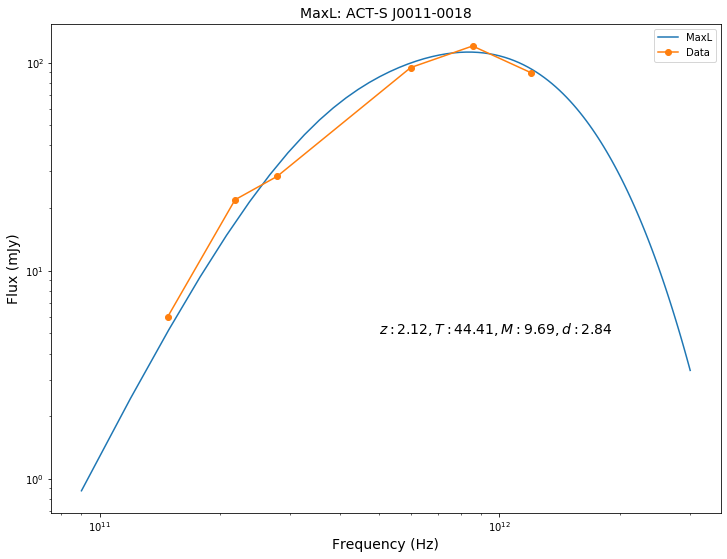

In [22]:
ml_S(ID[0],frecs0T) #maxima semejanza para Single

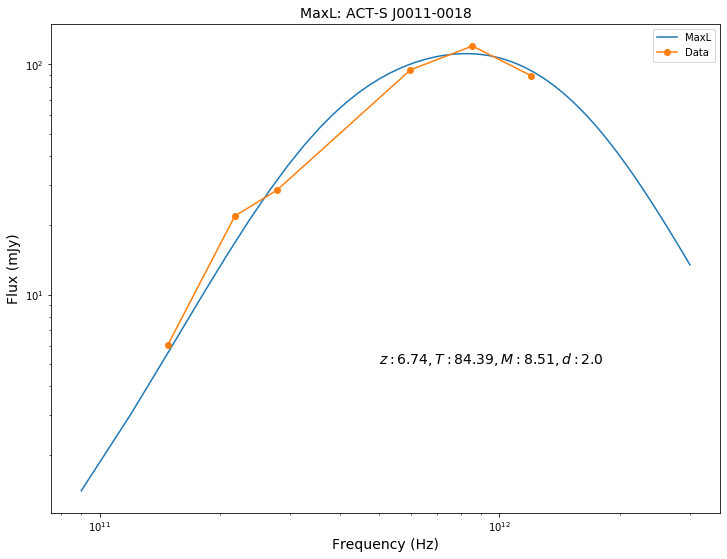

In [23]:
ml_PL_nolim(ID[0],frecs0T)  #maxima semejanza para PL sin limites, es decir, modelo sin tomar Tc entre 20 y 50K

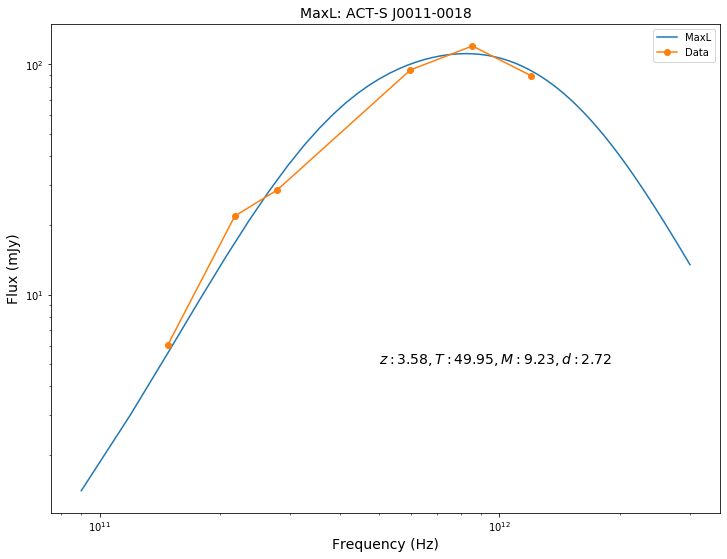

In [24]:
ml_PL_lim(ID[0],frecs0T)  #maxima semejanza para PL con limites, es decir, modelo tomando Tc entre 20 y 50K

In [25]:
from datetime import datetime

In [ ]:
startTime=datetime.now()
mcmc_S(ID[0],frecs0T,errf0T,"S") 
print(datetime.now()-startTime) #esto dura 40mins en mi pc 

De aquí en adelante se repiten las funciones en tods las galaxias de ACT.

ACT-S J0038_0022

In [ ]:
#frecs2T=[v1[2],v2[2],v3[2],l1[2],l2[2],l3[2]]
#errf2T=[ev1[2],ev2[2],ev3[2],el1[2],el2[2],el3[2]]

In [ ]:
#ml_S(ID[2],frecs2T)

In [ ]:
#ml_PL_nolim(ID[2],frecs2T)

In [ ]:
#ml_PL_lim(ID[2],frecs2T)

ACT-S J0039+0024

In [ ]:
#frecs3T=[v1[3],v2[3],v3[3],l1[3],l2[3],l3[3]]
#errf3T=[ev1[3],ev2[3],ev3[3],el1[3],el2[3],el3[3]]

In [ ]:
#ml_S(ID[3],frecs3T)

In [ ]:
#ml_PL_nolim(ID[3],frecs3T)

In [ ]:
#ml_PL_lim(ID[3],frecs3T)

ACT-S J0044+0118

In [ ]:
#frecs4T=[v1[4],v2[4],v3[4],l1[4],l2[4],l3[4]]
#errf4T=[ev1[4],ev2[4],ev3[4],el1[4],el2[4],el3[4]]

In [ ]:
#ml_S(ID[4],frecs4T)

In [ ]:
#ml_PL_nolim(ID[4],frecs4T)

In [ ]:
#ml_PL_lim(ID[4],frecs4T)

ACT-S J0045_0001

In [ ]:
#frecs5T=[v1[5],v2[5],v3[5],l1[5],l2[5],l3[5]]
#errf5T=[ev1[5],ev2[5],ev3[5],el1[5],el2[5],el3[5]]

In [ ]:
#ml_S(ID[5],frecs5T)

In [ ]:
#ml_PL_nolim(ID[5],frecs5T)

In [ ]:
#ml_PL_lim(ID[5],frecs5T)

ACT-S J0107+0001

In [ ]:
#frecs6T=[v1[6],v2[6],v3[6],l1[6],l2[6],l3[6]]
#errf6T=[ev1[6],ev2[6],ev3[6],el1[6],el2[6],el3[6]]

In [ ]:
#ml_S(ID[6],frecs6T)

In [ ]:
#ml_PL_nolim(ID[6],frecs6T)

In [ ]:
#ml_PL_lim(ID[6],frecs6T)

ACT-S J0116_0004

In [ ]:
#frecs7T=[v1[7],v2[7],v3[7],l1[7],l2[7],l3[7]]
#errf7T=[ev1[7],ev2[7],ev3[7],el1[7],el2[7],el3[7]]

In [ ]:
#ml_S(ID[7],frecs7T)

In [ ]:
#ml_PL_nolim(ID[7],frecs7T)

In [ ]:
#ml_PL_lim(ID[7],frecs7T)

ACT-S J0210+0016

In [ ]:
#frecs8T=[v1[8],v2[8],v3[8],l1[8],l2[8],l3[8]]
#errf8T=[ev1[8],ev2[8],ev3[8],el1[8],el2[8],el3[8]]

In [ ]:
#ml_S(ID[8],frecs8T)

In [ ]:
#ml_PL_nolim(ID[8],frecs8T)

In [ ]:
#ml_PL_lim(ID[8],frecs8T)